Моей задачей было добавить информативности диалогам для улучшения качества кластеризации и для этого разметить фразы (далее utterances) диалогов по сентименту, эмоциям и интентам. Нужно было опробовать несколько уже обученных моделей, оценить качество разметки и решить, стоит ли добавлять такую разметку в датасет. Затем собрать новый датасет с добавленными свойствами.

**В силу специфики задачи тестирование моего кода состоит из:**


*   **unit-тестирования функций, которые приводят датасет к нужному виду, получают и обрабатывают предсказания моделей (поскольку они однотипны для разных моделей, для удобства я взяла код для работы с одной моделью);**
*   **проверки итогового датасета;**
*   **тестирования и оценки качества использованных моделей.**



In [ ]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse

from tqdm.notebook import tqdm
import typing as tp
import numpy.typing as ntp

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Dataset downloading and processing

In [ ]:
import json
from pathlib import Path

def load_multiwoz(split, path='/content/drive/MyDrive/ML&Stats labs/innoprac_deeppavlov/multiwoz/data/MultiWOZ_2.2'):
    data_dir = Path(path) / split
    data = []
    data_parts = list(data_dir.iterdir())
    for data_part in tqdm(data_parts):
        with data_part.open() as f:
            data.extend(json.load(f))
    return data

In [ ]:
from itertools import accumulate

class Utterance:
    def __init__(self, utterance: str, speaker: str, turn_id: str, **meta: tp.Any):
        self.utterance = utterance
        self.speaker = speaker
        self.turn_id = turn_id
        self.meta = meta
    
    def __str__(self) -> str:
        return self.utterance
    
    def __repr__(self) -> str:
        return f"[{self.turn_id:>2}] {self.speaker:>8}: \"{self.utterance}\""
    
    @classmethod
    def from_multiwoz_v22(cls, utterance: tp.Dict[str, tp.Any]) -> 'Utterance':
        return cls(**utterance)
    

class Dialogue:
    def __init__(self, utterances: tp.List[Utterance], dialogue_id: str, **meta: tp.Any):
        self.utterances = utterances
        self.dialogue_id = dialogue_id
        self.meta = meta
    
    def __len__(self) -> int:
        return len(self.utterances)
    
    def __str__(self) -> str:
        return "\n".join(str(utt) for utt in self.utterances)
    
    def __repr__(self) -> str:
        return f"[{self.dialogue_id}]\n" + '\n'.join(repr(utt) for utt in self.utterances)
    
    def __getitem__(self, i) -> Utterance:
        return self.utterances[i]
    
    def __iter__(self) -> tp.Iterator[Utterance]:
        return iter(self.utterances)
        
    
    @classmethod
    def from_multiwoz_v22(cls, dialogue: tp.Dict[str, tp.Any]) -> 'Dialogue':
        utterances = [Utterance.from_multiwoz_v22(utt) for utt in dialogue['turns']]
        dialogue_id = dialogue['dialogue_id']
        meta = {key: val for key, val in dialogue.items() if key not in ['turns', 'dialogue_id']}
        return cls(utterances=utterances, dialogue_id=dialogue_id, **meta)


class DialogueDataset(list):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.utterances = [utt.utterance for dialog in self for utt in dialog]
        
        self._dialogue_start = list(accumulate([0] + [len(dialogue) for dialogue in self]))
        
        self._utt_dialogue_id = [0] * len(self.utterances)
        self._utt_id = [0] * len(self.utterances)
        for d_start in self._dialogue_start[1:-1]:
            self._utt_dialogue_id[d_start] = 1
        current_utt_id = 0
        for i in range(len(self._utt_id)):
            if self._utt_dialogue_id[i] == 1:
                current_utt_id = 0
            self._utt_id[i] = current_utt_id
            current_utt_id += 1
        self._utt_dialogue_id = list(accumulate(self._utt_dialogue_id))
        
        self._dial_id_mapping = {dialogue.dialogue_id: i 
                                for i, dialogue in enumerate(self)}
    
    def get_dialogue_by_idx(self, idx: int) -> Dialogue:
        udi = self._utt_dialogue_id[idx]
        return self[udi]
    
    def get_utterance_by_idx(self, idx: int) -> Utterance:
        udi = self._utt_dialogue_id[idx]
        ui = self._utt_id[idx]
        return self[udi][ui]
    
    def get_dialog_start_idx(self, dialogue: 'Dialog') -> int:
        dialogue_idx = self._dial_id_mapping[dialogue.dialogue_id]
        d_start = self._dialogue_start[dialogue_idx]
        return d_start
    
    @classmethod
    def from_miltiwoz_v22(cls, multiwoz_v22: tp.List[tp.Dict[str, tp.Any]]) -> 'DialogueDataset':
        dialogues = [Dialogue.from_multiwoz_v22(dialog) for dialog in multiwoz_v22]
        return cls(dialogues)

class Subset(DialogueDataset):
    def __init__(self, dialogues: DialogueDataset, subset: tp.Iterable):
        subset_dialogues = [dialogues[idx] for idx in subset]
        super().__init__(subset_dialogues)

In [ ]:
def get_split_data(split='test'):
    if split in ['test', 'dev', 'train']:
        return DialogueDataset.from_miltiwoz_v22(load_multiwoz(split))
    else:
        return None

In [ ]:
def dialogue_as_list(d):
    """
    Returns lists of phrases in Dialogue as a list of strings
    """
    lst = []
    ids = []
    speakers = []
    for phr in d:
        lst.append(str(phr))
        ids.append(phr.turn_id)
        speakers.append(phr.speaker)
    return lst, ids

## Bertweet-analysis

In [ ]:
!pip install pysentimiento

     |████████████████████████████████| 175 kB 5.5 MB/s 
     |████████████████████████████████| 312 kB 65.6 MB/s 
     |████████████████████████████████| 4.0 MB 61.5 MB/s 
     |████████████████████████████████| 77 kB 6.4 MB/s 
     |████████████████████████████████| 1.1 MB 48.9 MB/s 
     |████████████████████████████████| 212 kB 60.7 MB/s 
     |████████████████████████████████| 136 kB 57.8 MB/s 
     |████████████████████████████████| 127 kB 60.7 MB/s 
     |████████████████████████████████| 895 kB 37.1 MB/s 
     |████████████████████████████████| 596 kB 47.2 MB/s 
     |████████████████████████████████| 6.6 MB 30.9 MB/s 
     |████████████████████████████████| 144 kB 46.7 MB/s 
     |████████████████████████████████| 94 kB 3.0 MB/s 
     |████████████████████████████████| 271 kB 49.9 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=1325e34d14b79e646f5c191629ec1083fd973741829bbe6685ca5b6d12a932b9
  Stored in directory: /root/.cache/pip/whee

In [ ]:
from pysentimiento import create_analyzer

emotion_analyzer = create_analyzer(task="emotion", lang="en")
sentiment_analyzer = create_analyzer(task="sentiment", lang="en")

Downloading:   0%|          | 0.00/295 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/999 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/824k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/515M [00:00<?, ?B/s]

https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpvdds4n1d


Downloading:   0%|          | 0.00/295 [00:00<?, ?B/s]

storing https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/61374b71c02fdfd2929a3cdce24c242049e036624e15e18461a3a70cfc35e939.c260b44e952f7f2a825aac395f2ebbed4ac9553800d1e320af246e81a548f37c
creating metadata file for /root/.cache/huggingface/transformers/61374b71c02fdfd2929a3cdce24c242049e036624e15e18461a3a70cfc35e939.c260b44e952f7f2a825aac395f2ebbed4ac9553800d1e320af246e81a548f37c
https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpyyuwbp2i


Downloading:   0%|          | 0.00/890 [00:00<?, ?B/s]

storing https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/cb09766f7ba60b5f7a1bb640617b24f1499c4a6f3ab160c4a0ac171e3a377c68.008dca06003188334001a96363da79ced4944abc68d94a2f1e0db786dc5aa08b
creating metadata file for /root/.cache/huggingface/transformers/cb09766f7ba60b5f7a1bb640617b24f1499c4a6f3ab160c4a0ac171e3a377c68.008dca06003188334001a96363da79ced4944abc68d94a2f1e0db786dc5aa08b
loading configuration file https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/cb09766f7ba60b5f7a1bb640617b24f1499c4a6f3ab160c4a0ac171e3a377c68.008dca06003188334001a96363da79ced4944abc68d94a2f1e0db786dc5aa08b
Model config RobertaConfig {
  "_name_or_path": "finiteautomata/bertweet-base-sentiment-analysis",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_

Downloading:   0%|          | 0.00/824k [00:00<?, ?B/s]

storing https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/973dbacfdf4c488622f01d1a226089e9e3dba130a0c3c11c2e36d49466fa40a8.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
creating metadata file for /root/.cache/huggingface/transformers/973dbacfdf4c488622f01d1a226089e9e3dba130a0c3c11c2e36d49466fa40a8.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis/resolve/main/bpe.codes not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpzvbpjt6x


Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

storing https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis/resolve/main/bpe.codes in cache at /root/.cache/huggingface/transformers/0e474c44ff353f3b378fb140e7e6d4431df4ec6142e8b38d584c0dbc5afc3521.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
creating metadata file for /root/.cache/huggingface/transformers/0e474c44ff353f3b378fb140e7e6d4431df4ec6142e8b38d584c0dbc5afc3521.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis/resolve/main/added_tokens.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpbhdsunov


Downloading:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

storing https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis/resolve/main/added_tokens.json in cache at /root/.cache/huggingface/transformers/fe46927817477a58ec2aa92ef52f8ee6fc9e824d054f4aa6a3c129724dc9c9b7.c1e7052e39d2135302ec27455f6db22e1520e6539942ff60a849c7f83f8ec6dc
creating metadata file for /root/.cache/huggingface/transformers/fe46927817477a58ec2aa92ef52f8ee6fc9e824d054f4aa6a3c129724dc9c9b7.c1e7052e39d2135302ec27455f6db22e1520e6539942ff60a849c7f83f8ec6dc
https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpysnoba_i


Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

storing https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/9413ac0bed76140860deffa0c5a29ee4da7d49a3810da1b4b51b27f790bc9255.0dc5b1041f62041ebbd23b1297f2f573769d5c97d8b7c28180ec86b8f6185aa8
creating metadata file for /root/.cache/huggingface/transformers/9413ac0bed76140860deffa0c5a29ee4da7d49a3810da1b4b51b27f790bc9255.0dc5b1041f62041ebbd23b1297f2f573769d5c97d8b7c28180ec86b8f6185aa8
loading file https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/973dbacfdf4c488622f01d1a226089e9e3dba130a0c3c11c2e36d49466fa40a8.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/0e474c44ff353f3b378fb140e7e6d4431df4ec6142e8b38d584c0dbc5afc3

Downloading:   0%|          | 0.00/515M [00:00<?, ?B/s]

storing https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/2e4719cf8d097772eb75070b88cbc56f1d3b1392fffc5f75032a389ef21d1847.16366ca1277caccb15200478349503b3336a1420ac26d44fc16763354f5a2cae
creating metadata file for /root/.cache/huggingface/transformers/2e4719cf8d097772eb75070b88cbc56f1d3b1392fffc5f75032a389ef21d1847.16366ca1277caccb15200478349503b3336a1420ac26d44fc16763354f5a2cae
loading weights file https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/2e4719cf8d097772eb75070b88cbc56f1d3b1392fffc5f75032a389ef21d1847.16366ca1277caccb15200478349503b3336a1420ac26d44fc16763354f5a2cae
All model checkpoint weights were used when initializing RobertaForSequenceClassification.

All the weights of RobertaForSequenceClassification were initialized from the model checkpoint at finiteautomata/bertw

In [ ]:
# making dictionary with dialogues' utterances and predicted features
def label_dialoguedataset(dialogue_dataset):
  data = {}
  data['dialogues'] = []
  for dialogue in tqdm(dialogue_dataset):
    dialog_data = {}
    dialog_data['dialogue_id'] = dialogue.dialogue_id
    dialog_data['turns'] = []

    for uttr in dialogue:
        sentiment_prediction = sentiment_analyzer.predict(uttr.utterance)
        emotion_prediction = emotion_analyzer.predict(uttr.utterance)

        turn_data = {}
        turn_data['turn_id'] = uttr.turn_id
        turn_data['speaker'] = uttr.speaker
        turn_data['utterance'] = uttr.utterance
        turn_data['sentiment'] = sentiment_prediction.probas
        turn_data['emotion'] = emotion_prediction.probas
        dialog_data['turns'].append(turn_data)

    data['dialogues'].append(dialog_data) 

  return data

# Tests

## Unit-тестирование

In [ ]:
# Testing get_split_data
assert get_split_data('split') == None, "Incorrect function parameters"
assert type(get_split_data('test')) == DialogueDataset, "Incorrect data type"

print("Passed!")

  0%|          | 0/2 [00:00<?, ?it/s]

Passed!


In [ ]:
# Testing dialogue_as_list
test = get_split_data('test')

dialogue = None
for d in test:
    dialogue = d
    break

assert type(dialogue) == Dialogue, "Incorrect data type"

phrases_counter = 0
for phr in dialogue:
    phrases_counter += 1


phrases, inds = dialogue_as_list(dialogue)
assert type(phrases) == list, "Incorrect data type"
assert type(inds) == list, "Incorrect data type"
assert len(phrases) == phrases_counter, "Wrong len"
assert len(phrases) == len(inds), "phrases and inds must be of equal length"
for phrase in phrases:
    assert type(phrase) == str, "Phrases must be of str type"

print("Passed!")

  0%|          | 0/2 [00:00<?, ?it/s]

Passed!


In [ ]:
# Testing label_dialoguedataset
test = get_split_data('test')

dialogues = []
counter = 2
for d in test:
    dialogues.append(d)
    counter -= 1
    if counter == 0:
        break

labeled_dialogues = label_dialoguedataset(dialogues)
assert type(labeled_dialogues) == dict, "Incorrect data type"
assert type(labeled_dialogues['dialogues']) == list, "Incorrect data type"

for d in labeled_dialogues['dialogues']:
    assert type(d) == dict, "Incorrect data type"

    for turn in d['turns']:
        assert type(turn['speaker']) == str, "Incorrect data type"
        assert type(turn['utterance']) == str, "Incorrect data type"
        assert type(turn['sentiment']) == dict, "Incorrect data type"
        assert type(turn['emotion']) == dict, "Incorrect data type"

# Creating my own dialogue to check correct filling
uttrs = [Utterance(utterance="hi", speaker="None", turn_id=1), 
         Utterance(utterance="hello", speaker="None", turn_id=2),
         Utterance(utterance="how are you?", speaker="None", turn_id=3),
         Utterance(utterance="fine", speaker="None", turn_id=4)]
id = 123
my_dialogue = Dialogue(utterances=uttrs, dialogue_id=id)
my_labeled_dialogue = label_dialoguedataset([my_dialogue])

assert len(my_labeled_dialogue['dialogues']) == 1, "No dialogue info"
assert len(my_labeled_dialogue['dialogues'][0]['turns']) == 4, "Utterances missed"

assert my_labeled_dialogue['dialogues'][0]['turns'][2]['utterance'] == "how are you?", "Wrong phrase"
assert my_labeled_dialogue['dialogues'][0]['turns'][2]['turn_id'] == 3, "Wrong turn_id"
assert my_labeled_dialogue['dialogues'][0]['turns'][2]['speaker'] == "None", "Wrong speaker"
assert my_labeled_dialogue['dialogues'][0]['turns'][2]['sentiment']['NEU'] > 0, "No NEU label"


print("Passed!")

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Passed!


## Проверка датасетов

**Хорошей практикой является проверка датасетов на 'label leakage'. Поэтому давайте убедимся, что в итоговом датасете нет пропусков данных, а заодно проверим, что вектора (представляющие кластеры) имеют правильный shape.**

In [ ]:
!pip install datasets

     |████████████████████████████████| 325 kB 8.5 MB/s 
     |████████████████████████████████| 77 kB 6.7 MB/s 
     |████████████████████████████████| 1.1 MB 39.6 MB/s 
     |████████████████████████████████| 212 kB 69.9 MB/s 
     |████████████████████████████████| 136 kB 54.7 MB/s 
     |████████████████████████████████| 127 kB 66.6 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
     |████████████████████████████████| 271 kB 11.7 MB/s 
     |████████████████████████████████| 144 kB 43.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
from datasets import load_from_disk

dataset = load_from_disk('/content/drive/MyDrive/ML&Stats labs/innoprac_deeppavlov/promprog/Testing/sentiment_service_dataset').to_dict()
pd.DataFrame(dataset['clusters'], columns=['cluster_embedding', 'cluster_id', 'label', 'sentiment', 'services', 'size']).head()

,cluster_embedding,cluster_id,label,sentiment,services,size
0,"[-0.21947190165519714, 1.8991761207580566, -1.1714054346084595, -3.5083158016204834, -2.9204437732696533, 1.0794681310653687, 0.8966759443283081, 1.7798773050308228]",0,NEU,"{'NEG': 0.0, 'NEU': 0.8324324324324325, 'POS': 0.16756756756756758}","{'attraction': 0.1783783783783784, 'bus': None, 'hospital': None, 'hotel': 0.16216216216216217, 'restaurant': 1.0, 'taxi': 0.16756756756756758, 'train': 0.17297297297297298}",185
1,"[-0.5186834335327148, 0.9831191897392273, -0.015723921358585358, 1.8063241243362427, 1.9334909915924072, -0.002694884315133095, -1.7960450649261475, -0.6741338968276978]",1,NEU,"{'NEG': 0.01634877384196185, 'NEU': 0.8228882833787466, 'POS': 0.16076294277929154}","{'attraction': 0.29427792915531337, 'bus': None, 'hospital': None, 'hotel': 0.28610354223433243, 'restaurant': 0.3024523160762943, 'taxi': None, 'train': 1.0}",367
2,"[-1.0311092138290405, -1.9704093933105469, -1.8937528133392334, -0.038894325494766235, -2.304351329803467, 1.6538302898406982, 0.9969831705093384, -0.2817271947860718]",2,POS,"{'NEG': 0.0, 'NEU': 0.11914893617021277, 'POS': 0.8808510638297873}","{'attraction': 0.4553191489361702, 'bus': None, 'hospital': None, 'hotel': 0.14468085106382977, 'restaurant': 0.9659574468085106, 'taxi': 0.16170212765957448, 'train': 0.03404255319148936}",235
3,"[3.7558753490448, -0.7559008598327637, -1.277565598487854, 0.16757918894290924, 0.5791459083557129, -1.1328727006912231, -0.2582418620586395, -1.956923246383667]",3,NEU,"{'NEG': 0.004524886877828055, 'NEU': 0.751131221719457, 'POS': 0.24434389140271492}","{'attraction': 0.995475113122172, 'bus': None, 'hospital': None, 'hotel': 0.334841628959276, 'restaurant': 0.31221719457013575, 'taxi': 0.28054298642533937, 'train': 0.3031674208144796}",221
4,"[0.8544465899467468, 0.7752193212509155, 2.044132947921753, -1.245440125465393, -1.0097659826278687, -2.624732255935669, 1.7134100198745728, -0.34794294834136963]",4,NEU,"{'NEG': 0.0353356890459364, 'NEU': 0.6466431095406361, 'POS': 0.31802120141342755}","{'attraction': 0.303886925795053, 'bus': None, 'hospital': None, 'hotel': 1.0, 'restaurant': 0.23674911660777384, 'taxi': 0.19434628975265017, 'train': 0.21201413427561838}",283


In [ ]:
def print_result(name, value):
    if value == 0:
        print(f"No missing values in '{name}' column")
    else:
        print(f"Missing '{name}' in {value} rows")

#counters
emb_size = 8
none_labels = 0
none_sent = 0
none_serv = 0
none_size = 0

for cl in dataset['clusters']:
    assert len(cl['cluster_embedding']) == emb_size, "Wrong shape"
    
    if cl['label'] not in ['NEU', 'POS', "NEG"]:
        none_labels += 1
    
    if cl['sentiment'] is None:
        none_sent += 1
    
    if cl['services'] is None:
        none_serv += 1

    if cl['size'] is None or cl['size'] == 0:
        none_size += 1

print("All embeddings have correct shape")
print_result('label', none_labels)
print_result('sentiment', none_sent)
print_result('service', none_serv)
print_result('size', none_size)

All embeddings have correct shape
No missing values in 'label' column
No missing values in 'sentiment' column
No missing values in 'service' column
No missing values in 'size' column


## Проверка использованных моделей


Проверим на предложениях, для которых мы наверняка знаем ответ. Особенно уделим внимание предложениям со схожим смыслом, но немного разными словами.

In [ ]:
# positive phrases
pos = ["Ann is cool", 
       "Den is cool", 
       "He's great!",
       "I like apples",
       "I like bananas"]

# negative phrases
neg = ["I don't like bananas",
       "I have too many things to do", 
       "I have too much work to do",
       "it's disgusting",
       "the service is disgusting"]

# neutral
neu = ["She's working",
       "red carpet",
       "green carpet"]


pos_pred = sentiment_analyzer.predict(pos)
neg_pred = sentiment_analyzer.predict(neg)
neu_pred = sentiment_analyzer.predict(neu)

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 5
  Batch size = 32


  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 5
  Batch size = 32


  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 3
  Batch size = 32


In [ ]:
def compare_pred(preds: list, ans: str):
    wrong_cnt = 0
    for pred in preds:
        if pred.output != ans:
            wrong_cnt += 1
    return wrong_cnt

print("Number of wrong predictions {}".format( compare_pred(pos_pred, 'POS') + 
                                        compare_pred(neg_pred, 'NEG') + 
                                        compare_pred(neu_pred, 'NEU')))

Number of wrong predictions 0


In [ ]:
phrases_em = ["Wow, I like the present",                       # joy
              "The dress looks ridiculous",                    # disgust
              "I didn't expect that in any way.",              # surprise
              "I miss him",                                    # sadness
              "She misses him",                                # sadness
              "all friends missed her",                        # sadness
              "I'm worried about tomorrow's exam",             # fear
              "Everyone is worried about tomorrow's exam"]     # fear

correct_labels = ['joy', 'disgust', 'surprise', 'sadness', 'sadness', 'sadness', 'fear', 'fear']

emotion_prediction = emotion_analyzer.predict(phrases_em)

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 8
  Batch size = 32


In [ ]:
wrong_cnt = 0
for i in range(len(emotion_prediction)):
    if emotion_prediction[i].output != correct_labels[i]:
        wrong_cnt += 1

print(f"Number of wrong predictions {wrong_cnt}")

Number of wrong predictions 2


Классификатор по эмоциям делает ошибки даже на простых примерах. Классификатор по сентименту, на первый взгляд, справляется со своей задачей.

Для того чтобы полноценно оценить качество моделей, можно построить confusion matrix. Для этого нужно найти корректно размеченный датасет, получить для него предсказания модели и сравнить эти предсказания с правильными лэйблами.

В моей работе это было основным инструментом оценки качества классификаторов. 

Пример матриц ошибок для Bertweet классификаторов для эмоций и сентимента:

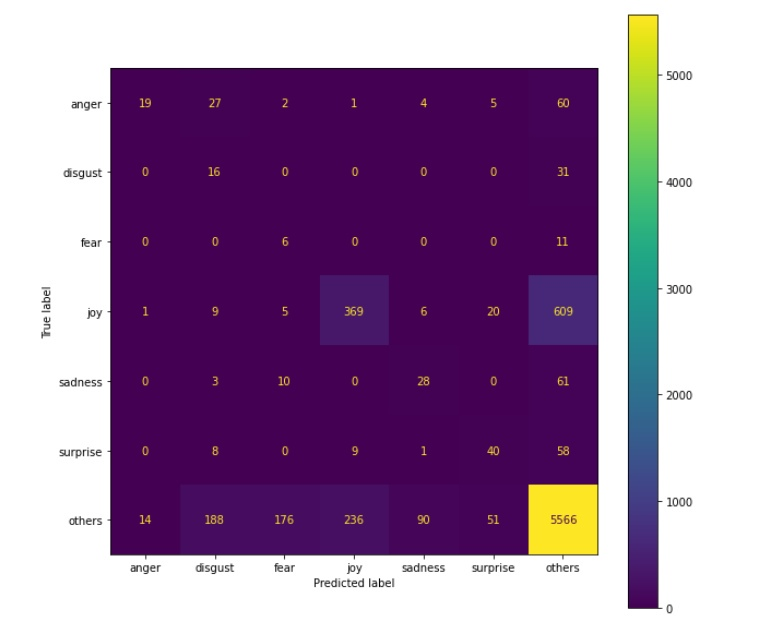

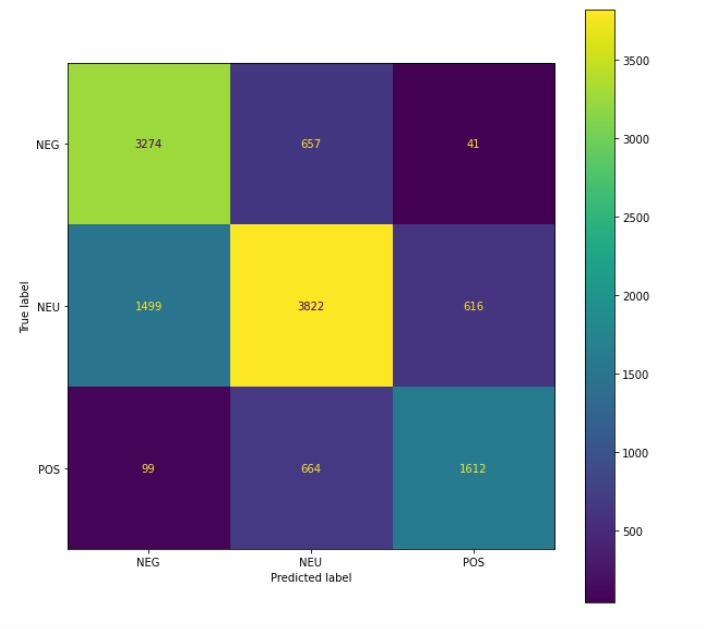